# Parameter space scan

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import re

plt.rcParams.update({'font.size': 14, 
                    'xtick.labelsize':14,
                    'ytick.labelsize':14,
                    'axes.labelsize': 14,
                    'axes.titlesize':14})


# Plotting everyone tastes everything

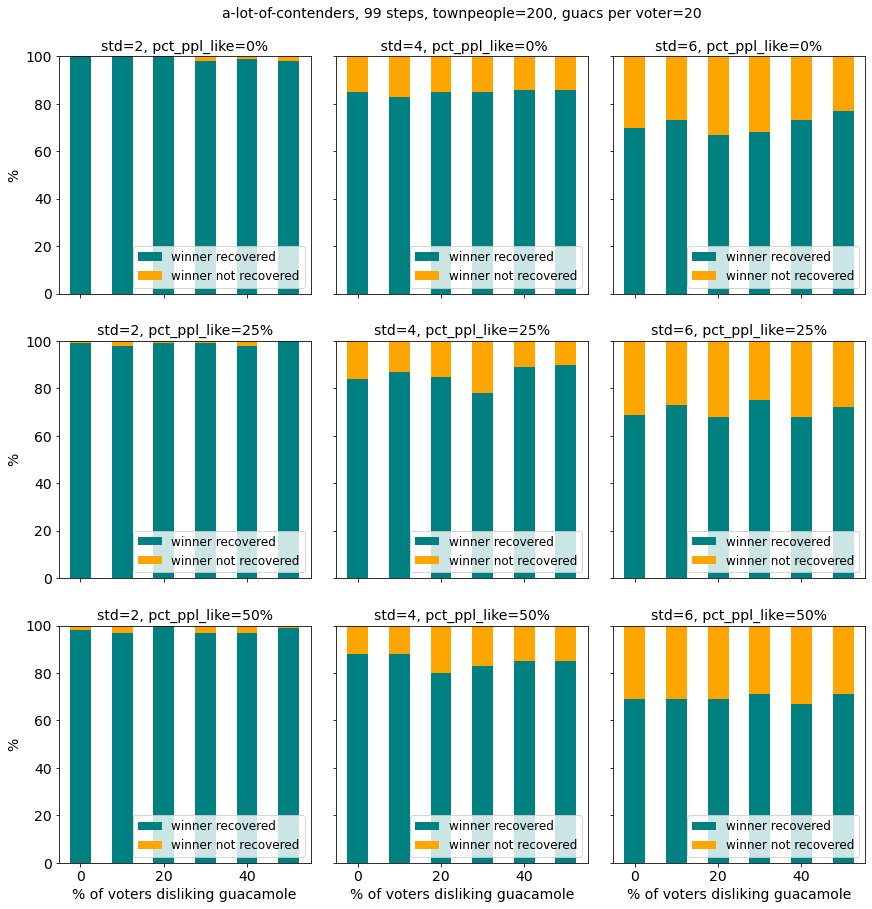

In [85]:
this_scenario = 'one-clear-winner'
this_scenario = 'a-lot-of-contenders'
filename = f"../data/param_space_scan_totalSim100_{this_scenario}_sum_20220408.csv"

#load the data
df = pd.read_csv(filename)

df.head()
simulation_steps = df['loop_step'].max()

#convert to string column with winner recovery info
df['true_winner_recovered'] = df['true_winner_recovered'].apply(lambda x: str(x).lower())


#considering 1 specific metric and scenario
this_metric = 'sum'
num_townspeople = df['num_townspeople'].tolist()[0]
num_guacs_per_voter = df['num_guacs_per_voter'].tolist()[0]

df = df[df['metric'] == this_metric]
df = df[df['scenario'] == this_scenario]

#create figure grid
nrows=3
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(14,14), sharex=True, sharey=True)


#loop over all std
counter_std = 0
for std in sorted(df['std'].unique()):
    
    #loop over all percentages of people liking guac
    counter_ppl = 0
    for ppl in sorted(df['pct_ppl_like'].unique()):
        
        #slice by dimensions and extract the quantities of interest
        df1 = df[df['pct_ppl_like'] == ppl]
        df1 = df1[df1['std'] == std][['pct_ppl_dislike', 'true_winner_recovered']]
        
        
        #create lists with counts of true and false for each value of pct_ppl_dislike for plotting
        ppd_list = sorted(df1['pct_ppl_dislike'].unique())
        true_list, false_list = [], []
        for ppd in ppd_list:
            df2 = df1[df1['pct_ppl_dislike'] == ppd]
            true_list.append(len(df2[df2['true_winner_recovered'] == 'true']))
            false_list.append(len(df2[df2['true_winner_recovered'] == 'false']))                      

        #plot the data
        my_width = 5
        axes[counter_ppl,counter_std].bar(ppd_list,true_list,label = 'winner recovered', color = 'teal', width = my_width)
        axes[counter_ppl,counter_std].bar(ppd_list,false_list,bottom=true_list, color = 'orange', label = 'winner not recovered', width = my_width)
        
        #add title and labels
        if counter_ppl == 0 and counter_std == 1:
            axes[counter_ppl,counter_std].set_title(f"{this_scenario}, {simulation_steps} steps, townpeople={num_townspeople}, guacs per voter={num_guacs_per_voter}\n\n std={std}, pct_ppl_like={ppl}%")
        else:
            axes[counter_ppl,counter_std].set_title(f"std={std}, pct_ppl_like={ppl}%")
        
        if counter_ppl == nrows-1:
            axes[counter_ppl,counter_std].set_xlabel('% of voters disliking guacamole')

        if counter_std == 0:
            axes[counter_ppl,counter_std].set_ylabel('%')
            
        #add legend
        axes[counter_ppl,counter_std].legend(loc=4, fontsize=12)
                
        counter_ppl += 1
    counter_std += 1

    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)  
plt.savefig(f"plots/{re.sub('.csv', '', filename.split('/')[-1])}_viz.png")

# Plotting everyone tastes a subset

In [81]:
filename1 = f"../data/param_space_scan_guacs_subset_totalSim200_townpeople100_a-lot-of-contenders_condorcet_20200408.csv"
df1 = pd.read_csv(filename1)
filename2 = f"../data/param_space_scan_guacs_subset_totalSim200_townpeople200_a-lot-of-contenders_condorcet_20200408.csv"
df2 = pd.read_csv(filename2)
filename3 = f"../data/param_space_scan_guacs_subset_totalSim200_townpeople300_a-lot-of-contenders_condorcet_20200408.csv"
df3 = pd.read_csv(filename3)


df = pd.concat([df1,df2, df3]).reset_index()
df.head()

del df['Unnamed: 0']
del df['index']

df.drop_duplicates(inplace = True)
df.head()


,metric,scenario,num_townspeople,std,pct_ppl_like,pct_ppl_dislike,loop_step,guac_20,guac_19,guac_18,...,guac_10,guac_9,guac_8,guac_7,guac_6,guac_5,guac_4,guac_3,guac_2,fraction_multiple_winners
0,condorcet,a-lot-of-contenders,100,2,33,33,0,True,True,True,...,True,True,True,True,True,False,True,True,True,0.0
1,condorcet,a-lot-of-contenders,100,2,33,33,1,True,True,True,...,True,False,True,True,False,True,False,False,False,0.0
2,condorcet,a-lot-of-contenders,100,2,33,33,2,True,True,True,...,False,False,False,False,True,True,True,True,True,0.0
3,condorcet,a-lot-of-contenders,100,2,33,33,3,True,False,False,...,True,True,False,True,False,False,False,False,True,0.0
4,condorcet,a-lot-of-contenders,100,2,33,33,4,True,True,True,...,True,False,True,True,True,True,True,False,True,0.0


100
200
300
100
200
300
100
200
300


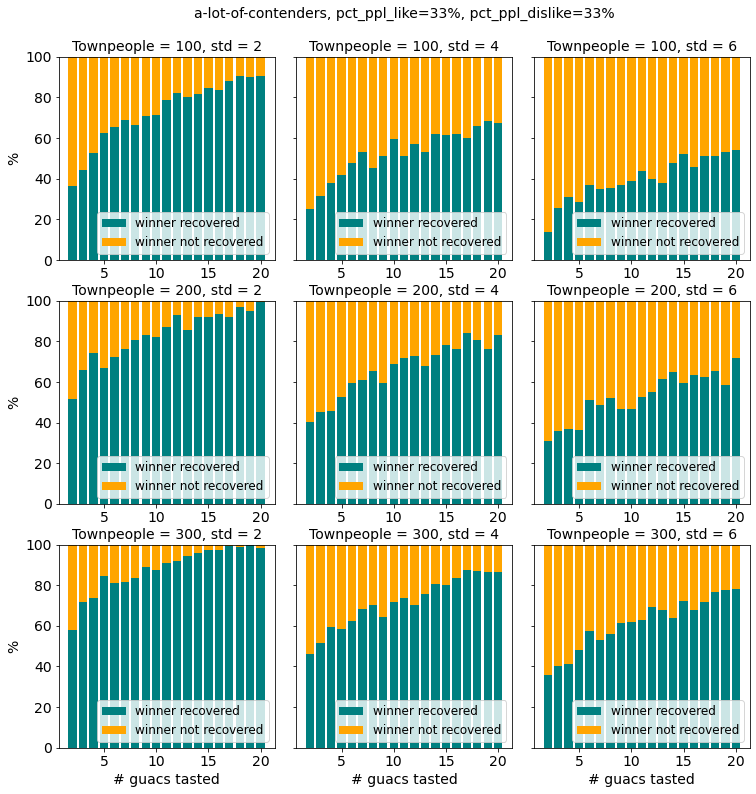

In [84]:
#load the data
df = df[df['metric'] == 'condorcet'].copy()

#get total number of simulations
number_simulations = len(df['loop_step'].unique())

#get columns containing true/false/not_all_assigned
guac_cols = [col for col in df.columns if 'guac_' in col]

#make it a string
for gc in guac_cols:
    df[gc] = df[gc].apply(lambda x: str(x).lower())

#create a 3x3 grid to contain different standard deviations and and different assumptions 
#about town people counts
nrows=3
ncols=3
#fig, axes = plt.subplots(nrows, ncols, figsize=(12,12), sharex=False, sharey=True)
fig, axes = plt.subplots(nrows, ncols, figsize=(12,12), sharex=False, sharey=True)
scenario = df['scenario'].tolist()[0]

pct_ppl_like = df['pct_ppl_like'].tolist()[0]
pct_ppl_dislike = df['pct_ppl_dislike'].tolist()[0]


#loop over standard deviations
counter_std = 0
for std in df['std'].unique():
    df_std = df[df['std']==std].copy()

    #loop over number of townpeople
    counter_nt = 0
    for nt in df['num_townspeople'].unique():
        print(nt)

        df_nt = df_std[df_std['num_townspeople'] == nt].copy()
        df_nt.set_index(['loop_step'], inplace = True)
        df_nt = df_nt[guac_cols].copy()

        #transpose it to count the different options
        df_ntt = df_nt.T        
        df_ntt['num_true'] = df_ntt.apply(lambda x: 100.*get_count(x,'true')/number_simulations,1)
        df_ntt['num_false'] = df_ntt.apply(lambda x: 100.*get_count(x,'false')/number_simulations,1)
        df_ntt['num_not_all_assigned'] = df_ntt.apply(lambda x: 100.*get_count(x,'not_all_assigned')/number_simulations,1)

        df_ntt['guac_id'] = df_ntt.index
        df_ntt['guac_id'] = df_ntt['guac_id'].apply(lambda x: int(x.split('_')[-1]))
        
        #plot the different configurations as stacked bar plots
        if nrows == 1:
            use_ax = axes[counter_std]
        else:
            use_ax = axes[counter_nt,counter_std]
        use_ax.bar(df_ntt['guac_id'].tolist(), 
                                         df_ntt['num_true'].tolist(), 
                                         color = 'teal', 
                                         label = 'winner recovered'
                                        )
        use_ax.bar(df_ntt['guac_id'].tolist(), 
                                         df_ntt['num_false'].tolist(), 
                                         bottom = df_ntt['num_true'].tolist(), 
                                         color = 'orange', 
                                         label = 'winner not recovered'
                                        )
#         use_ax.bar(df_ntt['guac_id'], 
#                                          df_ntt['num_not_all_assigned'], 
#                                          bottom = df_ntt['num_true'] + df_ntt['num_false'], 
#                                          color = 'red', 
#                                          label = 'not all guacs assigned'
#                                         )
        #fix the limit on the y axis to allow comparisons
        use_ax.set_ylim(0, 100)

        #add parameters to the figure
        if counter_nt == 0 and counter_std == 1:
            use_ax.set_title(f"{scenario}, pct_ppl_like={pct_ppl_like}%, pct_ppl_dislike={pct_ppl_like}%\n\nTownpeople = {nt}, std = {std}")
        else:
            use_ax.set_title(f"Townpeople = {nt}, std = {std}")

        #add legend
        use_ax.legend(loc=4, fontsize=12)

        #add labels
        if counter_std == 0:
            use_ax.set_ylabel('%')
        if counter_nt == nrows-1:
            use_ax.set_xlabel('# guacs tasted')

        if nrows > 1:
            counter_nt+=1
            
    counter_std+=1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)  
plt.savefig(f"plots/{re.sub('.csv', '', filename.split('/')[-1])}_viz.png")